## Methods to compare in integration tasks

Harmony and Liger are widely-used data integration / batch effect correction methods that have Python implementations. Harmony is usually considered to be less aggressive in strength, thus keeping more biological variance. Liger is suitable in situations with more severe batch effect.

In [1]:
import os

import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import numpy as np

In [14]:
import scanpy as sc
import squidpy as sq

In [5]:
import harmonypy as hm
import pyliger
import scanorama

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


## Load data and view the data without integration

In [108]:
adata = sc.read_h5ad("E:/retina-merfish/VZA105a_integrated_368genes.h5ad")
adata

AnnData object with n_obs × n_vars = 113385 × 368
    obs: 'sampleid', 'volume', 'center_x', 'center_y', 'assigned_transcripts', 'region', 'majorclass', 'subclass'

In [109]:
pd.Series(adata.X.sum(axis=1)).describe()

count    113385.000000
mean         34.858078
std          32.986626
min           9.000000
25%          15.000000
50%          24.000000
75%          42.000000
max         713.000000
dtype: float64

In [110]:
adata.obsm['spatial'] = adata.obs[['center_x', 'center_y']].to_numpy()

In [111]:
adata.obs

,sampleid,volume,center_x,center_y,assigned_transcripts,region,majorclass,subclass
1046-0,VZG105a_WT1,2316.0,-2587.418,-4853.984,15.0,4,AC,AC_6
1052-0,VZG105a_WT1,739.5,-2356.044,-4523.536,33.0,4,Rod,Rod
1097-0,VZG105a_WT1,3189.5,4217.766,-4062.678,15.0,3,BC,BC5B
1146-0,VZG105a_WT1,2386.5,-3360.364,2759.678,185.0,1,Rod,Rod
1286-0,VZG105a_WT1,2787.0,217.496,6382.412,11.0,0,Rod,Rod
...,...,...,...,...,...,...,...,...
979016-3,VZG105a_WT4,1362.0,496.930,-5127.694,10.0,7,Rod,Rod
980016-3,VZG105a_WT4,7500.5,507.838,-5070.238,31.0,7,Cone,Cone
982016-3,VZG105a_WT4,3914.0,508.162,-5077.852,19.0,7,Rod,Rod
983016-3,VZG105a_WT4,2742.0,535.432,-5167.870,19.0,7,BC,BC3B


In [112]:
adata.obs['sample_region'] = adata.obs['sampleid'].astype(str) + '_' + adata.obs['region'].astype(str)

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\pandas\core\arrays\categorical.py:568: RuntimeWarning: invalid value encountered in cast


In [113]:
pd.crosstab(adata.obs['sample_region'], adata.obs['majorclass'])

majorclass,AC,BC,Cone,HC,MG,RGC,Rod
sample_region,,,,,,,
VZG105a_WT1_0,376,360,111,39,173,61,1554
VZG105a_WT1_1,41,22,4,2,7,6,61
VZG105a_WT1_2,236,294,142,29,98,50,1366
VZG105a_WT1_3,122,183,151,13,61,9,1163
VZG105a_WT1_4,510,736,152,64,231,59,2517
VZG105a_WT2_0,614,750,219,41,190,145,2420
VZG105a_WT2_1,1154,1041,198,58,344,177,3426
VZG105a_WT2_2,781,823,244,55,227,117,3864
VZG105a_WT2_3,963,1024,233,46,278,168,4183


... storing 'sample_region' as categorical


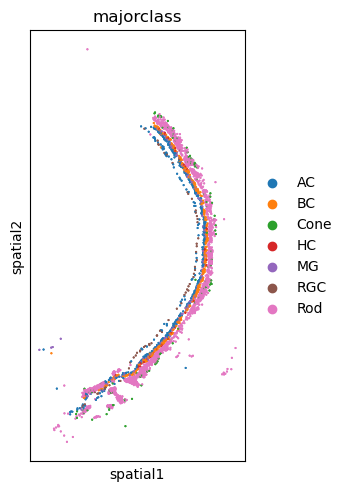

In [114]:
%matplotlib inline
sq.pl.spatial_scatter(adata[adata.obs['sample_region'] == 'VZG105a_WT1_0', :], color='majorclass', shape=None, size=1.)
pass

... storing 'sample_region' as categorical


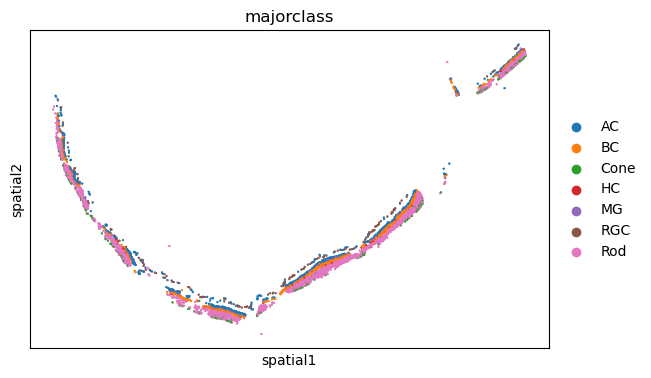

In [115]:
%matplotlib inline
sq.pl.spatial_scatter(adata[adata.obs['sample_region'] == 'VZG105a_WT2_0', :], color='majorclass', shape=None, size=1.)
pass

In [116]:
batch = 'sample_region'
label = 'majorclass'

## PCA (w/o correction)

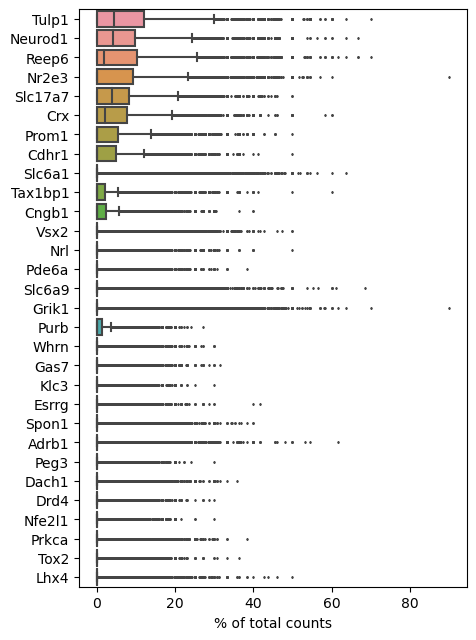

In [117]:
sc.pl.highest_expr_genes(adata)

In [118]:
adata.raw = adata.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

... storing 'sample_region' as categorical


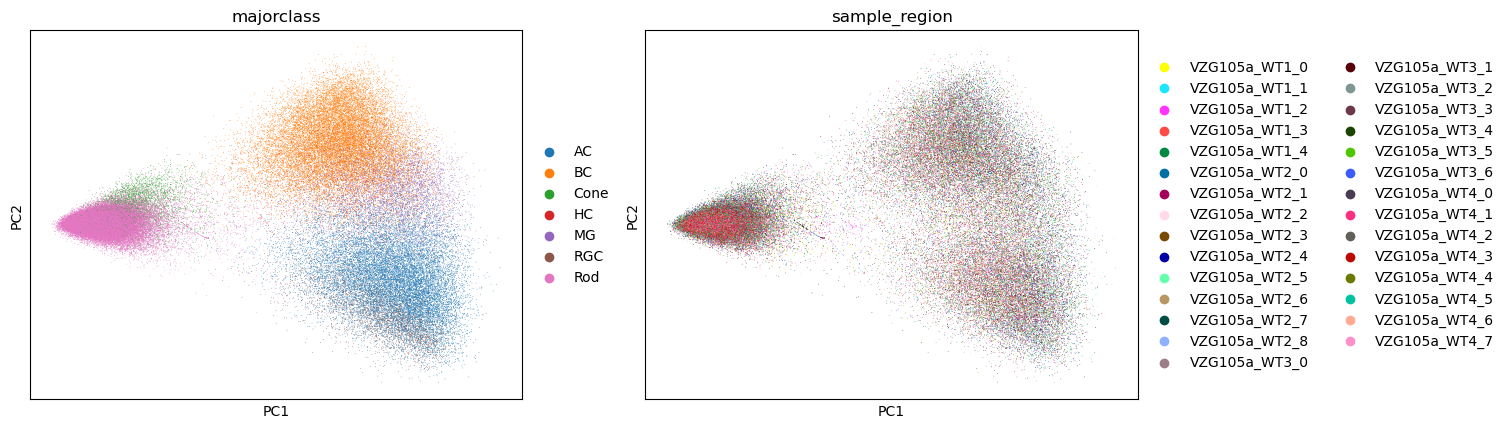

In [119]:
sc.tl.pca(adata)
sc.pl.pca(adata, color=[label, batch])

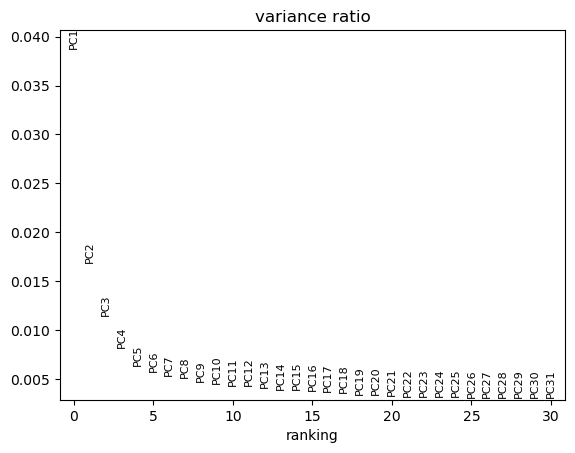

In [120]:
sc.pl.pca_variance_ratio(adata)

In [101]:
sc.pp.neighbors(adata, n_pcs=12)
sc.tl.umap(adata)

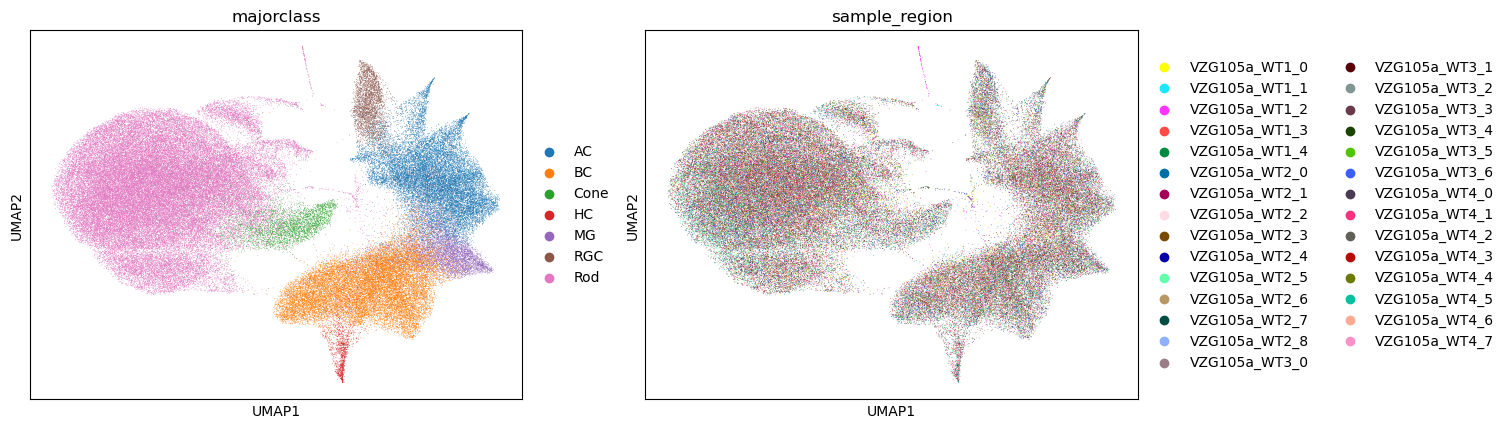

In [102]:
%matplotlib inline
sc.pl.umap(adata, color=[label, batch])
pass

In [106]:
(adata.X == 0).sum(axis=1).max()

0

## Harmony integration

In [71]:
ho = hm.run_harmony(adata.obsm['X_pca'][:, :12], adata.obs[[batch]], [batch])

2023-10-06 16:38:16,714 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2023-10-06 16:38:29,468 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2023-10-06 16:38:30,177 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-10-06 16:39:22,483 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-10-06 16:40:13,948 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-10-06 16:41:05,616 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-10-06 16:41:57,351 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


In [72]:
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
adata.obsm['X_harmony'] = res.to_numpy().T

In [73]:
sc.pp.neighbors(adata, use_rep='X_harmony')
sc.tl.umap(adata)

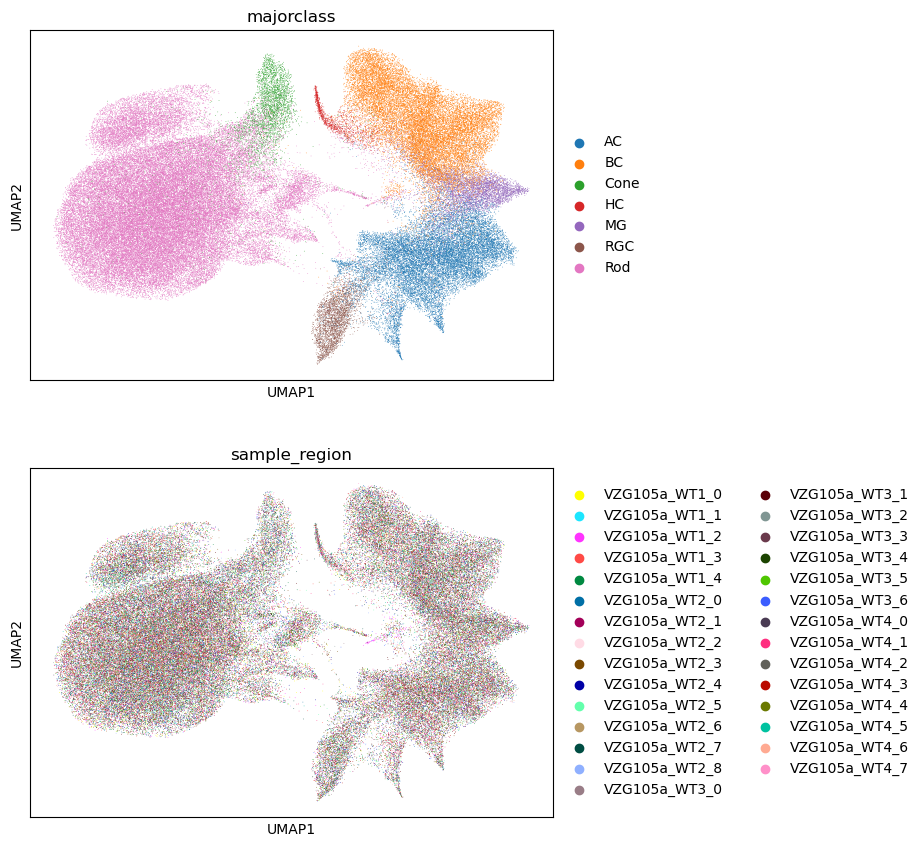

In [74]:
%matplotlib inline
sc.pl.umap(adata, color=[label, batch], ncols=1)
pass

## Liger

In [130]:
adatas = []
for i in adata.obs[batch].unique():
    adatas.append(adata.raw.to_adata()[adata.obs[batch] == i, :])
    adatas[-1].obs.index.name = 'cell_names'
    adatas[-1].var.index.name = 'gene_names'
    adatas[-1].uns['sample_name'] = i
    
liger = pyliger.create_liger(adatas)

Removing 4 genes not expressing in VZG105a_WT1_3.
Index(['Areg', 'Gdf3', 'Tagln2', 'Tpm2'], dtype='object', name='gene_names')
Removing 68 genes not expressing in VZG105a_WT1_1.
Removing 1 genes not expressing in VZG105a_WT1_0.
Index(['Pantr1'], dtype='object', name='gene_names')
Removing 1 genes not expressing in VZG105a_WT1_2.
Index(['Areg'], dtype='object', name='gene_names')
Removing 5 genes not expressing in VZG105a_WT3_3.
Index(['Bmp2', 'Ceacam10', 'Fosb', 'Lmo3', 'Mfap5'], dtype='object', name='gene_names')
Removing 8 genes not expressing in VZG105a_WT3_4.
Index(['4833423E24Rik', 'Areg', 'Crybb3', 'Fosb', 'Gdf3', 'Rxfp3', 'Serpinb1b',
       'Slc16a7'],
      dtype='object', name='gene_names')
Removing 1 genes not expressing in VZG105a_WT3_2.
Index(['Rarres1'], dtype='object', name='gene_names')
Removing 72 genes not expressing in VZG105a_WT4_2.
Removing 8 genes not expressing in VZG105a_WT4_7.
Index(['Bmp2', 'Gm12371', 'Gng7', 'Isl2', 'Mfap5', 'Serpinb1b', 'Sgcz',
       'Zeb2'

In [131]:
pyliger.normalize(liger)
pyliger.select_genes(liger)
pyliger.scale_not_center(liger)
pyliger.optimize_ALS(liger, k = 20)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:47<00:00,  7.58s/it]


In [132]:
pyliger.quantile_norm(liger)

In [133]:
adata.obsm['X_liger'] = np.vstack([adata.obsm["H_norm"] for adata in liger.adata_list])

In [134]:
sc.pp.neighbors(adata, use_rep='X_liger', metric='cosine')
sc.tl.umap(adata)

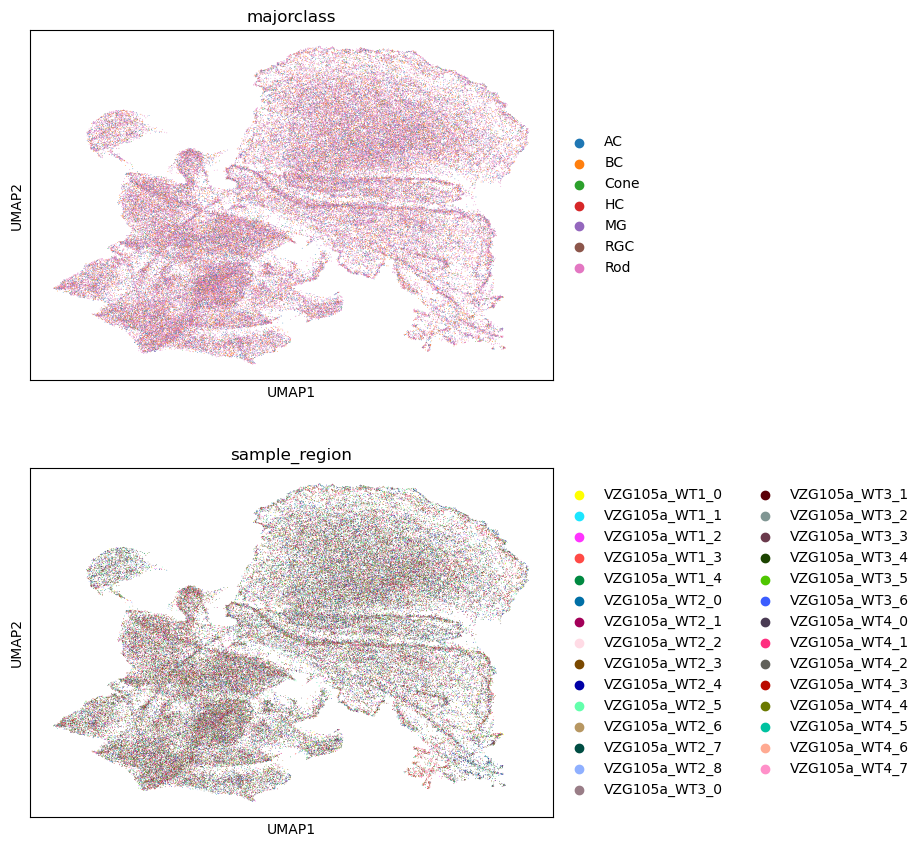

In [135]:
%matplotlib inline
sc.pl.umap(adata, color=[label, batch], ncols=1)
pass

## Scanorama

In [138]:
adatas = []
for i in adata.obs[batch].unique():
    adatas.append(adata.raw.to_adata()[adata.obs[batch] == i, :])
    adatas[-1].obs.index.name = 'cell_names'
    adatas[-1].var.index.name = 'gene_names'
    adatas[-1].uns['sample_name'] = i
    

In [ ]:
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 368 genes among all datasets
[[0.         0.43830787 0.53146853 0.34106208 0.32776524 0.31084563
  0.27547435 0.2187866  0.19067697 0.18856875 0.1543687  0.18669478
  0.17076599 0.18739752 0.13328648 0.11147541 0.10014205 0.12224939
  0.08933718 0.09055118 0.11272898 0.09182478 0.09966777 0.0720524
  0.10869056 0.07308503 0.07563025 0.06535488 0.09404389]
 [0.         0.         0.28671329 0.30846063 0.25323149 0.24324324
  0.2173913  0.19506463 0.20387779 0.17097532 0.15511163 0.17802585
  0.17273796 0.153349   0.1586369  0.11280846 0.04900568 0.13513514
  0.05757932 0.04724409 0.08343126 0.10164512 0.05315615 0.05346651
  0.12690952 0.06462985 0.04759107 0.05992949 0.05485893]
 [0.         0.         0.         0.32867133 0.27272727 0.37062937
  0.25174825 0.27272727 0.24475524 0.23776224 0.26573427 0.25174825
  0.21678322 0.17482517 0.16783217 0.11188811 0.07692308 0.12587413
  0.07692308 0.03496503 0.13986014 0.0979021  0.02797203 0.05594406
  0.12587413 0.13986014 0.04195804

Processing datasets (24, 26)
Processing datasets (0, 1)
Processing datasets (17, 20)
Processing datasets (5, 6)
Processing datasets (9, 13)
Processing datasets (25, 27)
Processing datasets (26, 27)
Processing datasets (23, 24)
Processing datasets (24, 27)
Processing datasets (6, 7)
Processing datasets (5, 7)
Processing datasets (11, 13)
Processing datasets (25, 26)
Processing datasets (21, 22)
Processing datasets (25, 28)
Processing datasets (7, 9)
Processing datasets (6, 13)
Processing datasets (5, 9)
Processing datasets (24, 28)
Processing datasets (6, 9)
Processing datasets (26, 28)
Processing datasets (7, 13)
Processing datasets (21, 23)
Processing datasets (2, 5)
Processing datasets (12, 13)
Processing datasets (21, 24)
Processing datasets (23, 25)
Processing datasets (23, 27)
Processing datasets (10, 13)
Processing datasets (9, 11)
Processing datasets (5, 13)
Processing datasets (9, 10)
Processing datasets (17, 19)
Processing datasets (14, 17)
Processing datasets (21, 26)
Process

In [ ]:
adata.obsm['X_scanorama'] = np.vstack([corrected[i].obsm['X_scanorama'] for i in range(len(adatas))])

In [ ]:
sc.pp.neighbors(adata, use_rep='X_scanorama', metric='cosine')
sc.tl.umap(adata)

In [ ]:
%matplotlib inline
sc.pl.umap(adata, color=[label, batch], ncols=1)
pass

## Scoring and plotting 

In [ ]:
adata.write("output/mouse-retina-368-integration.h5ad")